In [1]:
from network_generators import erdos_renyi_graph
import numpy as np
import networkx as nx
from graph_diffusion import GraphDiffusion
from netrd.distance import *
import netrd
import matplotlib.pyplot as plt
import datetime as dt
import itertools as it
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
def LJ(G1, G2):
    D = LaplacianSpectral()
    d = D.dist(G1, G2, kernel='lorentzian')
    return d

def LE(G1, G2):
    D = LaplacianSpectral()
    d = D.dist(G1, G2, kernel='lorentzian', measure='euclidean')
    return d

def NJ(G1, G2):
    D = LaplacianSpectral()
    d = D.dist(G1, G2)
    return d

def NE(G1, G2):
    D = LaplacianSpectral()
    d = D.dist(G1, G2, measure='euclidean')
    return d

all_distance_function_names = ['Jaccard','Hamming','HammingIpsenMikhailov','Frobenius',
                               'PolynomialDissimilarity','DegreeDivergence','PortraitDivergence',
                               'QuantumJSD','CommunicabilityJSD','GraphDiffusion','ResistancePerturbation',
                               'NetLSD','LaplacianSpectralGJS','LaplacianSpectralEUL','IpsenMikhailov',
                               'NonBacktrackingSpectral','DistributionalNBD','DMeasure','DeltaCon','NetSimile']

all_distance_functions = [JaccardDistance().dist, Hamming().dist, HammingIpsenMikhailov().dist,
                          Frobenius().dist, PolynomialDissimilarity().dist, DegreeDivergence().dist,
                          PortraitDivergence().dist, QuantumJSD().dist, CommunicabilityJSD().dist,
                          GraphDiffusion().dist, ResistancePerturbation().dist, NetLSD().dist,
                          NJ, LE, IpsenMikhailov().dist, NonBacktrackingSpectral().dist, DistributionalNBD().dist,
                          DMeasure().dist, DeltaCon().dist, NetSimile().dist]

all_distances = dict(zip(all_distance_function_names, all_distance_functions))

better_names = ["Jaccard dissimilarity\n[JAC]",
                "Hamming distance\n[HAM]",
                "Hamming-Ipsen-Mikhailov\n[HIM]",
                "Frobenius norm\n[FRO]",
                "Polynomial dissimilarity\n[POD]",
                "Degree distribution\nJensen-Shannon div. [DJS]",
                "Portrait divergence\n[POR]",
                "Quantum density matrix\nJensen-Shannon div. [QJS]",
                "Communicability sequence\nentropy [CSE]",
                "Graph diffusion distance\n[GDD]",
                "Resistance perturbation\ndistance [REP]",
                "NetLSD\n[LSD]",
                "Laplacian (Gaussian kernel)\nJensen-Shannon div. [LGJ]",
                "Laplacian (Lorenzian kernel)\nEuclidean distance [LLE]",
                "Ipsen-Mikhailov\n[IPM]",
                "Nonbacktracking spectral\ndistance [NBD]",
                "Distribributional nonbactracking\nspectral distance [DNB]",
                "D-measure distance\n[DMD]",                
                "DeltaCon\n[DCN]",
                "NetSimile\n[NES]"
               ]
title_dict = dict(zip(all_distance_function_names,better_names))

In [3]:
df_out = pd.DataFrame(columns=['ensemble', 'n', 'param_label', 'param_value', 'distance_label', 'd'])

# example runthrough: ER networks, varying average degree logarithmically

In [4]:
ensemble = 'gnk'
n = 100
param_label = 'k'
gran = 21
kvals = np.logspace(-2,np.log10(n),gran).round(6)
ntimes = 4

for ki, k in enumerate(kvals):
    if ki % 4==0:
        print("%02i"%ki, dt.datetime.now())
    for _ in range(ntimes):
        G1 = erdos_renyi_graph(n, k)
        G2 = erdos_renyi_graph(n, k)

        for dist_name, distance_i in all_distances.items():
            try:
                d_i = distance_i(G1, G2)
            except Exception as e:
                print(ki, k, dist_name, e)
                d_i = np.nan

            df_i = pd.DataFrame({'ensemble':[ensemble],'n':[n],'param_label':[param_label],
                                 'param_value':[k],'distance_label':[dist_name],'d':[d_i]})
            df_out = pd.concat([df_out, df_i])
            
print("Done at:", dt.datetime.now())
df_out = df_out.sort_values('param_value').reset_index().iloc[:,1:]

00 2020-09-30 18:20:45.391036
0 0.01 Jaccard division by zero
0 0.01 ResistancePerturbation Resistance perturbation is undefined for disconnected graphs.
0 0.01 NonBacktrackingSpectral Graph has no nodes or edges
0 0.01 DistributionalNBD Graph two-core is empty: non-backtracking methods unsuitable.
0 0.01 DMeasure Found infinite path length because the graph is not connected
0 0.01 ResistancePerturbation Resistance perturbation is undefined for disconnected graphs.
0 0.01 NonBacktrackingSpectral Graph has no nodes or edges
0 0.01 DistributionalNBD Graph two-core is empty: non-backtracking methods unsuitable.
0 0.01 DMeasure Found infinite path length because the graph is not connected
0 0.01 ResistancePerturbation Resistance perturbation is undefined for disconnected graphs.
0 0.01 NonBacktrackingSpectral Graph has no nodes or edges
0 0.01 DistributionalNBD Graph two-core is empty: non-backtracking methods unsuitable.
0 0.01 DMeasure Found infinite path length because the graph is not 

In [5]:
group_cols = ['ensemble','n','param_label','param_value','distance_label']
means = df_out.groupby(group_cols).agg({'d':np.nanmean}).reset_index()
stdvs = df_out.groupby(group_cols).agg({'d':np.nanstd}).reset_index()
means = means.rename(columns={'d':'d_mean'})
stdvs = stdvs.rename(columns={'d':'d_stdv'})
wegdf = means.merge(stdvs, how='left', on=group_cols)
param_label = wegdf['param_label'].unique()[0]

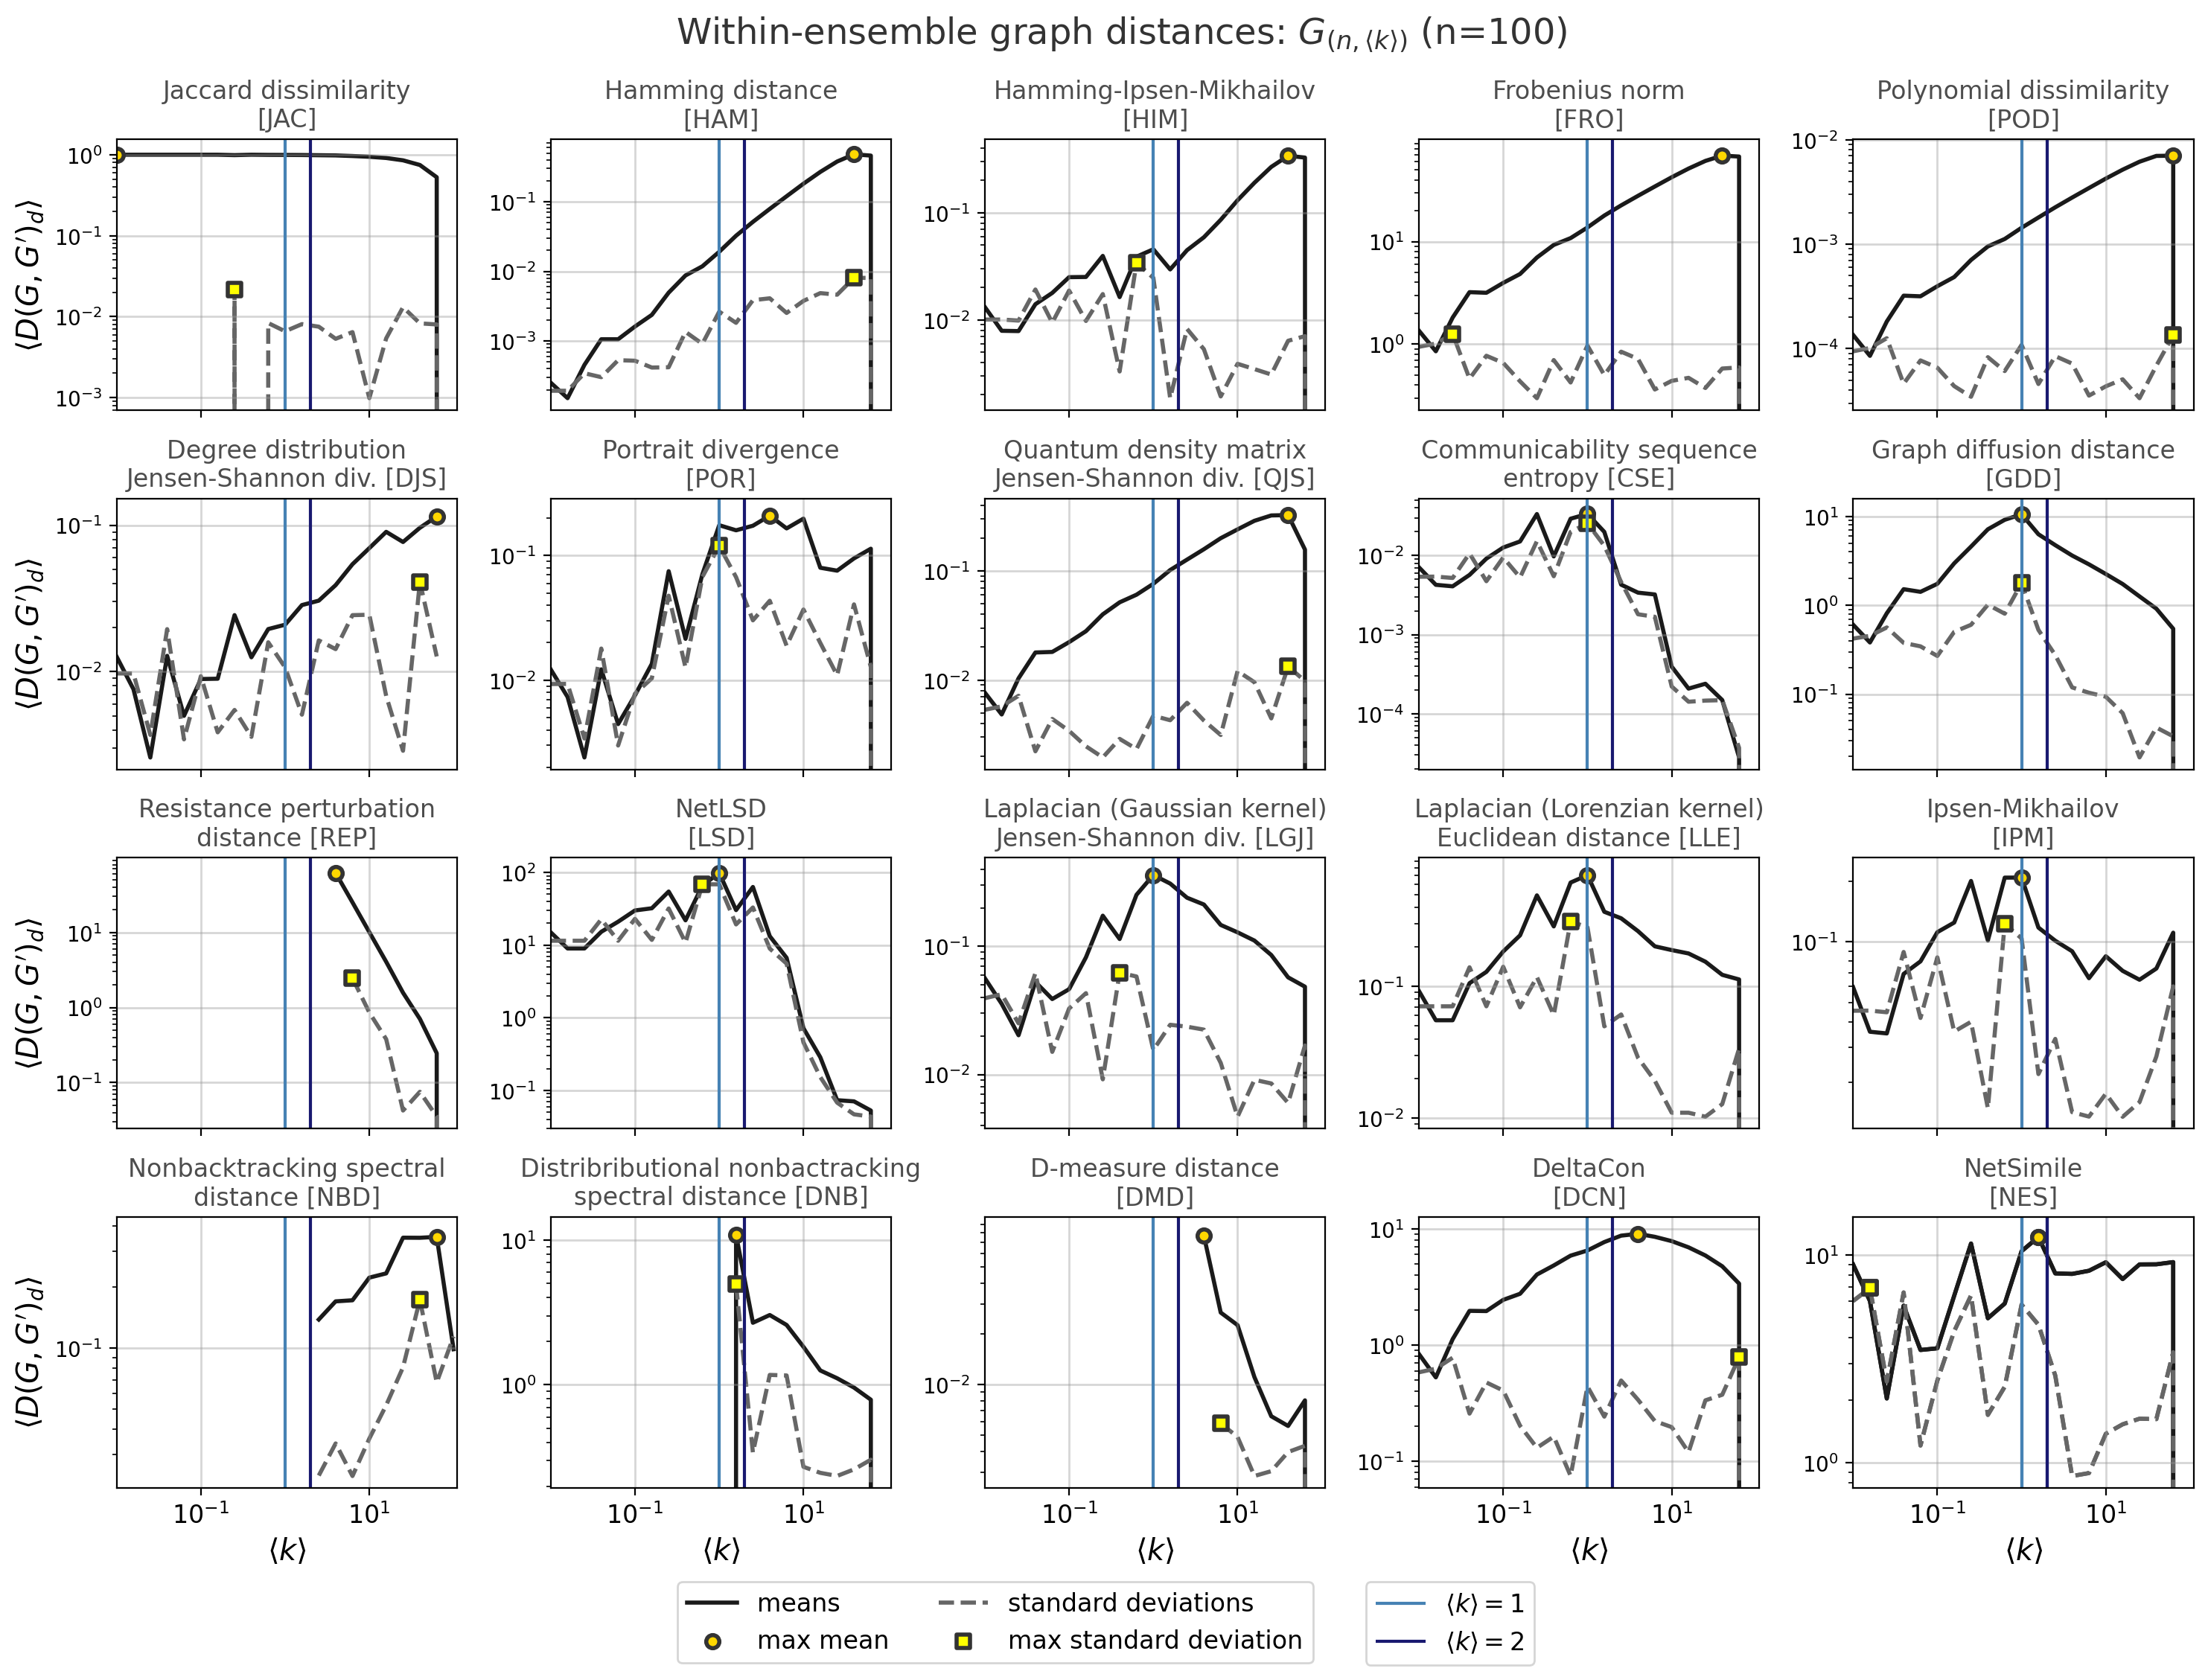

In [6]:
ncols = 5
nrows = 4
w = 3.6
h = 3.0

tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=200, sharex=True)

plt.subplots_adjust(wspace=0.275,hspace=0.325)

for ai, tup in enumerate(tups):
    d_lab = all_distance_function_names[ai]
    df_i = wegdf.loc[(wegdf['distance_label']==d_lab)].copy()
    xvals_i = df_i['param_value'].values
    means_i = df_i['d_mean'].values
    stdvs_i = df_i['d_stdv'].values
    max_i_mean = xvals_i[np.argmax(np.nan_to_num(means_i))]
    max_i_stdv = xvals_i[np.argmax(np.nan_to_num(stdvs_i))]
    
    ax[tup].plot(xvals_i, means_i, color='.1', linewidth=2, zorder=0)
    ax[tup].plot(xvals_i, stdvs_i, color='.4', linewidth=2, zorder=0, linestyle='--')
    ax[tup].scatter([max_i_mean], [np.nanmax(means_i)], c='gold', edgecolors='.2', lw=2, s=40)
    ax[tup].scatter([max_i_stdv], [np.nanmax(stdvs_i)], c='yellow', edgecolors='.2', lw=2, s=40, marker='s')

    ax[tup].set_title(title_dict[d_lab],fontsize='large',color='.3')
    ax[tup].grid(linewidth=1, color='.6', alpha=0.4)
                 
    ax[tup].set_yscale('log')
    ax[tup].set_xscale('log')
    ylim_i = ax[tup].get_ylim()
    ydiff = ylim_i[1] - ylim_i[0]
    ylim_i = (ylim_i[0], ylim_i[1]+0.1*ydiff)
    ax[tup].set_ylim(ylim_i[0], ylim_i[1])
    ax[tup].set_xlim(kvals[0]-1e-5, kvals[-1]+1e1)
    ax[tup].vlines(1, ylim_i[0], ylim_i[1], color='steelblue')
    ax[tup].vlines(2, ylim_i[0], ylim_i[1], color='midnightblue')

    if tup[0] == 3:
        ax[tup].set_xlabel(r'$\langle %s \rangle$'%param_label,fontsize='x-large')
        ax[tup].xaxis.set_tick_params(labelsize='large')

        if tup[1] == ncols-1:
            v1 = ax[tup].vlines(1, ylim_i[0], ylim_i[1], color='steelblue', label=r'$\langle k \rangle = 1$')
            v2 = ax[tup].vlines(2, ylim_i[0], ylim_i[1], color='midnightblue', label=r'$\langle k \rangle = 2$')

            legend2 = ax[tup].legend([v1, v2], [r'$\langle k \rangle = 1$', r'$\langle k \rangle = 2$'],
                                     bbox_to_anchor=[-0.9,-0.3], ncol=1, fontsize='large')
            m1, = ax[tup].plot(xvals_i, means_i, color='.1', linewidth=2, zorder=0, 
                              label='means')
            maxm = ax[tup].scatter([max_i_mean], [np.nanmax(means_i)], c='gold',
                                   edgecolors='.2', lw=2, s=40, label='max mean')
            s1, = ax[tup].plot(xvals_i, stdvs_i, color='.4', linewidth=2, zorder=0, linestyle='--',
                              label='standard deviations')
            maxs = ax[tup].scatter([max_i_stdv], [np.nanmax(stdvs_i)], c='yellow',
                                   edgecolors='.2', lw=2, s=40, label='max standard deviation', marker='s')
            
            legend1 = ax[tup].legend([m1, maxm, s1, maxs],
                                     ['means', 'max mean', 'standard deviations', 'max standard deviation'],
                                     bbox_to_anchor=[-1.55,-0.3], ncol=2, fontsize='large')
            ax[tup].add_artist(legend2)

    if tup[1] == 0:
        ax[tup].set_ylabel(r"$\langle D(G, G')_d \rangle$",fontsize='x-large')
    
plt.suptitle(r'Within-ensemble graph distances: $G_{(n, \langle k \rangle)}$ (n=%i)'%(n),
             fontsize='xx-large', y=0.95, color='.2')

plt.savefig('../figs/pngs/%s_wegd_%s_n%i.png'%(ensemble,param_label,n),bbox_inches='tight',dpi=425)
plt.savefig('../figs/pdfs/%s_wegd_%s_n%i.pdf'%(ensemble,param_label,n),bbox_inches='tight')

plt.show()